![](https://www.cell.com/pb-assets/ux3/logos/cell/star-protocols3-1615557520987.svg)


[//]: ![](https://www.ncbi.nlm.nih.gov/corehtml/pmc/pmcgifs/logo-starprot.png)

## Protocol
# Integrative systems biology pipeline to elucidate central nodes of viral pathogenesis.

# SUMMARY

### In humans, the pathophysiology is complex and challenging to investigate. To study human pathophysiology, we took an integrated network-biology-transcriptome approach. Using data from five sources, we constructed a comprehensive human interactome based on high-quality interaction protein-protein interactions. Based on the viral protein targets and transcriptome data of HPV and HSV samples, viral targets and transcriptome-specific human interactome (VTTSHI) were generated. Topological clustering and pathway enrichment analysis were used to identify nodes pivotal to viral pathogenicity.

In [41]:
__author__ = "Nilesh Kumar"
__copyright__ = "Copyright 2022, STAR Procol"
__credits__ = ["Nilesh Kumar"]
__license__ = "GPL"
__version__ = "1.0.2"
__maintainer__ = "Nilesh Kumar"
__email__ = "nilesh.iiita@gmail.com"
__status__ = "Production"

### For complete details on the use and execution of this protocol, please refer to Kumar et al. (2020).

## Highlights


- Integration of Human interactome, viral target, and transcriptome data.
- The viral target for HVP and HSV.
- Topological clustering and pathway enrichment analysis

## Clone the protocol directory

### Time: ~5 min

The Python notebook and most of the required data sets for running this protocol can be found on the GitHub repository (VTTSHI).

```
git@github.com:nilesh-iiita/VTTSHI.git
```

    1. Clone the protocol directory from the GitHub repository by using the command below from the Linux command-line interface:

```
git clone https://github.com/nilesh-iiita/VTTSHI
```

    Alternatively, go to https://github.com/nilesh-iiita/VTTSHI and select 'Download Zip' under the 'Code' button to download the pipeline.


## Download datasets

## Make sure all essential data and directorires are all set in the path.

    4. In the Jupyter notebook, if you use the tree command, you can determine the exact location of the "VTTSHI" directory.

        a. Check all PPIs
    
        ```python
        !tree VTTSHI/D1_Network_data -P *.tsv
        ```



In [42]:
!tree D1_Network_data -P *.tsv

D1_Network_data
├── BioPlex_3
│   ├── BioPlex.tsv
│   └── BioPlex_net.tsv
├── CoFrac
│   ├── CoFrac_net.tsv
│   ├── __MACOSX
│   │   └── nature14871-s2
│   └── nature14871-s2
├── HuRI_db
│   ├── HI-union.tsv
│   └── HuRI_Union_net.tsv
├── QUBIC
│   └── QUBIC_net.tsv
└── STRING_db
    └── STRING_exp_net.tsv

8 directories, 7 files


        b. Check all the datasets associated with viral protein targets.
        
        ```python
        !tree VTTSHI/HPIDB_data/ -P *.tsv
        ```
    
    

    c. Verify the transcriptome data that you have.
    
    ```python
    tree VTTSHI/Transcriptome -P *.csv
    ```

## MATERIALS AND EQUIPMENT

## MATERIALS AND EQUIPMENT

Python software and required Python packages: Although newer versions are available of some of these packages, this protocol was developed with Python v3.10.2, IPython v7.31.0, and Notebook v6.4.7. Other python packages and respective versions are enlisted in the "Key resources table" (packaged by conda-forge). 

Hardware Recommendations
- Operating system: GNU/Linux (Red Hat Enterprise Linux Server release 7.9 (Maipo) recommended).
- Memory: ~16 GB (memory requirement depends on the size of the dataset).
- Processors: 5 recommended.

A large part of this protocol relies on Python 3 scripts and a few Linux utilities (get, unzip, etc.). Furthermore, for network analysis, Cytoscape is used, which is available for macOS, Windows, and Linux. RNA-Seq analysis (GSE124118 and GSE74927) is described separately and not here, and the DESeq2 R library is recommended for expression analysis (https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8). As a whole, this protocol is recommended for GNU/Linux, but it can be easily adapted to work with all popular OS distributions and is completely open-source. 


# STEP-BY-STEP METHOD DETAILS

The protocol includes seven parts, from PPIs to network comparisons to getting pathogenic target proteins, and everything in between. Each of these sections is described in more detail below. 

>> CRITICAL: Using "VTTSHI_STAR_Protocol.ipynb" excute all python script and Shell commands step-by-step.

## Part 1: Load PPIs.

>> TIMING: ~1 min (computational time scales with PPIs integrate and available resources)

In [43]:
import pandas as pd
from glob2 import glob
from collections import defaultdict
import networkx as nx
from pathlib import Path
from upsetplot import UpSet, from_contents
from copy import copy
import urllib.parse
import urllib.request
import gseapy as gp
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import session_info
import warnings
warnings.filterwarnings('ignore')

2. Load and prepare PPIs with the NetworkX and Pandas Python package.
<br>
    
    2.a. Make sure all network files are in the path. Every network is stored as a tab-separated edge list (*_net.tsv). Use the following command to check all "*_net.tsv" is in the path.
    
    <br>
    <br>
    
    ```Python
    !tree D1_Network_data/ -P *_net.tsv
    ```
    

    2.b. Use the script below in order to read network data as a pandas dataframe.

In [44]:
Network_files = glob('D1_Network_data//*/*_net.tsv')

Network_dfs = defaultdict(dict)
Network_Graphs = defaultdict(dict)
Network_Nodes = defaultdict(dict)

for Network_file in Network_files:
    Net_name = Network_file.split('/')[-1].replace('_net.tsv', '')
    df = pd.read_csv(Network_file, sep="\t")
    Network_dfs[Net_name] = df
    G = nx.from_pandas_edgelist(df, 'IDa', 'IDb')
    G.remove_edges_from(nx.selfloop_edges(G))
    Network_Graphs[Net_name] = G
    nodes = set(df.IDa.unique()).union(set(df.IDb.unique()))
    Network_Nodes[Net_name] = nodes
    
print(f"List of Networks as dataframe {list(Network_dfs)}")

print(f"List of Networks as Graph object{list(Network_Graphs)}")
print(f"List of Networks Nodes list {list(Network_Nodes)}")

List of Networks as dataframe ['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp']
List of Networks as Graph object['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp']
List of Networks Nodes list ['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp']


    3. To merge networks, use the following script.

In [45]:
List_of_dfs = list(Network_dfs.values())
df_network = pd.concat(List_of_dfs)
df_network.drop_duplicates(inplace=True)
df_network.head()

,IDa,IDb
0,P00813,A5A3E0
1,Q8N7W2,P26373
2,Q8N7W2,Q09028
3,Q8N7W2,Q9Y3U8
4,Q8N7W2,P36578


## Part 2: Load viral target data

>> TIMING: ~1 min

    1. Ensure that all viral target datasets are in the path by using the following command.


In [46]:
!tree HPIDB_data/**/*.tsv

HPIDB_data/Herpes/herpes_viruses_pathogen_species.mitab_plus.tsv [error opening dir]
HPIDB_data/Papillomaviruses/papillomaviruses_pathogen_species.mitab_plus.tsv [error opening dir]

0 directories, 0 files


    2. Run the following command to load the viral data.

In [47]:
Viral_target = defaultdict(dict)

Viral_files = glob('HPIDB_data/*/*.mitab_plus.tsv')
for Viral_file in Viral_files:
    V_name = Viral_file.split('/')[-1].split('_')[0].title()
    # print(V_name)
    df = pd.read_csv(Viral_file, sep="\t")
    # print(df)
    df_arrt = df.copy()
    df_arrt[list(df_arrt)[-1]] = V_name + "_target"
    df_arrt.to_csv(Viral_file.replace('mitab_plus.tsv', "mitab_plus_attr.txt"), index=False, sep=" ")
    Human_proteins = set(df.Human.unique())
    # print(Human_proteins)
    Viral_target[V_name] = Human_proteins
    
    # break
    
list(Viral_target)

['Herpes', 'Papillomaviruses']

    3. The following Python function checks for overlap between viral targets and individual PPI networks.

In [48]:
def Upset_protein(Target):
    
    Uset_data = defaultdict(dict)
    print('>', list(Network_Nodes))
    Uset_data = copy(Network_Nodes)
    Uset_data[Target] = Viral_target[Target]
    print(list(Uset_data))    
    return Uset_data

    3.a To make a plot of HVP overlaps, follow the script below. 

> ['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp']
['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp', 'Papillomaviruses']


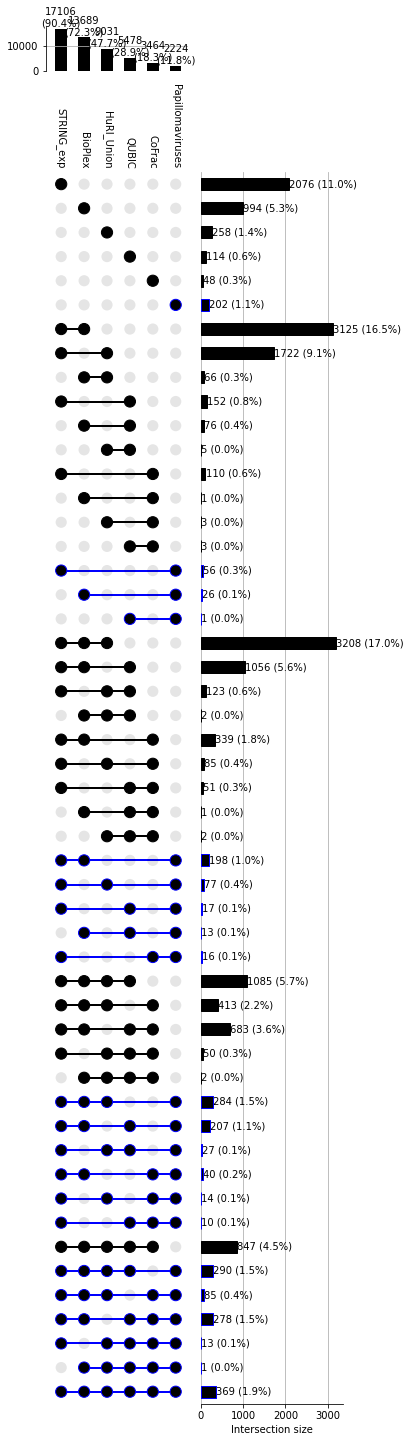

In [49]:
Data = Upset_protein('Papillomaviruses')
# print(list(Data))
Data = from_contents(Data)
Data
upset = UpSet(Data, show_counts='%d', show_percentages=True, shading_color=.0, other_dots_color=.1, orientation='vertical')

upset.style_subsets(present="Papillomaviruses", edgecolor="blue", linewidth=1)

Path("Images").mkdir(parents=True, exist_ok=True)
upset.plot()
fig = plt.gcf()
fig.savefig("Images/Upset_HPV.png")
fig.savefig("Images/Upset_HPV.pdf")
# fig.show()

del(Data)

    3.b To make a plot of HSP overlaps, follow the script below. 

> ['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp']
['BioPlex', 'CoFrac', 'HuRI_Union', 'QUBIC', 'STRING_exp', 'Herpes']


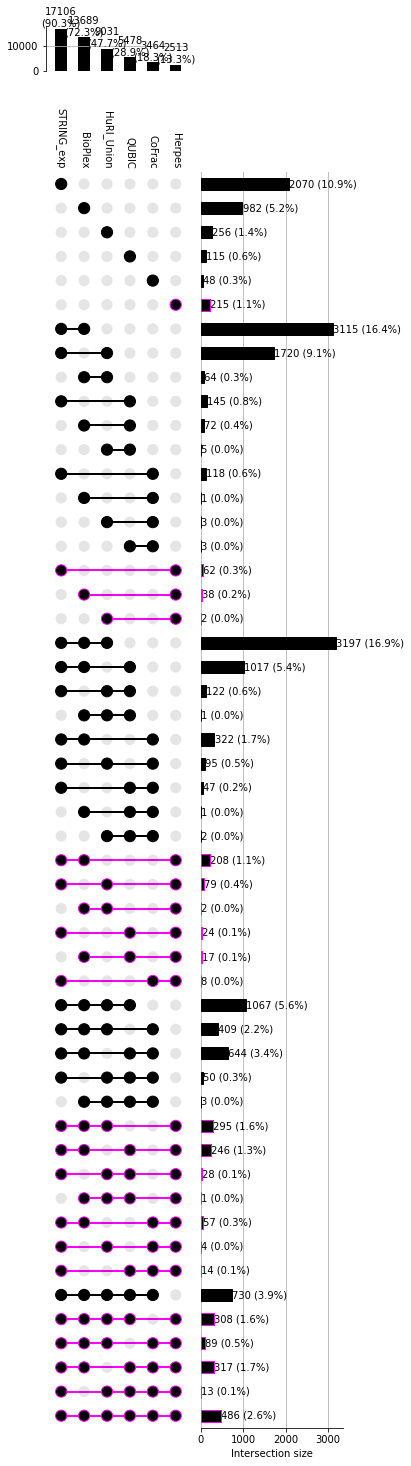

In [50]:
Data = Upset_protein('Herpes')

Data = from_contents(Data)
Data
upset = UpSet(Data, show_counts='%d', show_percentages=True, shading_color=.0, other_dots_color=.1, orientation='vertical')

upset.style_subsets(present="Herpes", edgecolor="magenta", linewidth=1)
Path("Images").mkdir(parents=True, exist_ok=True)



upset.plot()
fig = plt.gcf()
fig.savefig("Images/Upset_HSV.png")
fig.savefig("Images/Upset_HSV.pdf")
del(Data)

>> CRITICAL:  Only about 1 percent of viral protein targets do not overlap with PPI datasets in both cases. It is imperative to minimize non-overlapping protein targets. 

## Part 3: Load transcritomics data

TIMING: ~1 min

    1. Ensure that all transcriptomics files are in the path. All networks should be in a comma-separated edge list. (*_net.csv) format. Check that all "*.csv" files are in the path using the following command.

```Python
!tree Transcriptome/**/*00_DEDeq2_Data**/*.csv
```


    2. Use the following script to load transcriptomics data.

In [51]:
Herpes_df = pd.read_csv("Transcriptome/Herpes_GSE124118/00_DEDeq2_Data_HSV/hsv_cells_Skin_vs_lung.csv")
Herpes_exp = set(Herpes_df[Herpes_df.padj <= 0.05].UNIPROT.dropna())

Papillomavirus_df = pd.read_csv("Transcriptome/Papillomavirus_GSE74927/00_DEDeq2_Data_HPV/hpv_status_HPV_vs_Neg.csv")
Papillomavirus_exp = set(Papillomavirus_df[Papillomavirus_df.padj <= 0.05].UNIPROT.dropna())

print(f"Number of expressed genes in HSV:{len(Herpes_exp)}")
print(f"Number of expressed genes in HPV:{len(Papillomavirus_exp)}")

Number of expressed genes in HSV:1725
Number of expressed genes in HPV:3078


In [52]:
# Herpes_exp = set(Herpes_df[Herpes_df.pvalue <= 0.05].UNIPROT.dropna())
# Papillomavirus_exp = set(Papillomavirus_df[Papillomavirus_df.pvalue <= 0.05].UNIPROT.dropna())

>> CRITICAL:  To eliminate genes that are not significantly expressed, only a q-value (padj *= 0.05) filter is used. However, other filters can be applied, depending on the circumstances. P-value can be used in place of q-value, for example. 

## Part 4. Itegrate PPI with Viral protein target with Viral transcriptome data.

>> TIMING: ~1 min

    1. The following Python function combines the network edges list and target (protein targets) and generates the open target network and close target network edges lists. Each edge in an open target network contains at least one target node (protein target). In contrast, in a close target network, both nodes of an edge list should be protein' (Viral) targets.

In [53]:
Network_Dir = "Network_data/"

def df_nx(df, Targets):
    LOL = df.values.tolist() #[:10]
    Open = []
    Close = []
    
    for a,b in LOL:
        # print(a,b)
        if a in Targets and b in Targets:
            Close.append([a,b])
        
        if a in Targets or b in Targets:
            Open.append([a,b])

    O = nx.Graph()
    O.add_edges_from(Open)
    O.remove_edges_from(nx.selfloop_edges(O))
    
    C = nx.Graph()
    C.add_edges_from(Close)
    C.remove_edges_from(nx.selfloop_edges(C))

    print(O)
    print(C)
    return O, C

    1.a. Integrate PPIs with viral (HSV) targets with transcriptome data using the following Python script and make an open target and close target network. We will refer to the integrated network as VTTSHI-HSV.

In [54]:
Count_info = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))


O, C = df_nx(df_network, Viral_target['Herpes'])
Out_Dir = Network_Dir + "Herpes/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O, Out_Dir + 'Herpes' + "_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C, Out_Dir + 'Herpes' + "_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Herpes']['Viral_target']['Open']['Node'] = O.number_of_nodes()
Count_info['Herpes']['Viral_target']['Open']['Edges'] = O.number_of_edges()

Count_info['Herpes']['Viral_target']['Close']['Node'] = C.number_of_nodes()
Count_info['Herpes']['Viral_target']['Close']['Edges'] = C.number_of_edges()


# # print(nx.to_pandas_edgelist(O))

O_exp_O, O_exp_C = df_nx(nx.to_pandas_edgelist(O), Herpes_exp)
Out_Dir = Network_Dir + "Herpes/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O_exp_O, Out_Dir + 'Herpes' + "_Open_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(O_exp_C, Out_Dir + 'Herpes' + "_Open_exp_Close_edgelist.nx", delimiter=' ', data=False)


Count_info['Herpes']['Viral_expressed_open']['Open']['Node'] = O_exp_O.number_of_nodes()
Count_info['Herpes']['Viral_expressed_open']['Open']['Edges'] = O_exp_O.number_of_edges()

Count_info['Herpes']['Viral_expressed_open']['Close']['Node'] = O_exp_C.number_of_nodes()
Count_info['Herpes']['Viral_expressed_open']['Close']['Edges'] = O_exp_C.number_of_edges()

C_exp_O, C_exp_C = df_nx(nx.to_pandas_edgelist(C), Herpes_exp)
Out_Dir = Network_Dir + "Herpes/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(C_exp_O, Out_Dir + 'Herpes' + "_Close_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C_exp_C, Out_Dir + 'Herpes' + "_Close_exp_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Herpes']['Viral_expressed_close']['Open']['Node'] = C_exp_O.number_of_nodes()
Count_info['Herpes']['Viral_expressed_close']['Open']['Edges'] = C_exp_O.number_of_edges()

Count_info['Herpes']['Viral_expressed_close']['Close']['Node'] = C_exp_C.number_of_nodes()
Count_info['Herpes']['Viral_expressed_close']['Close']['Edges'] = C_exp_C.number_of_edges()


Graph with 16557 nodes and 247923 edges
Graph with 2263 nodes and 50368 edges
Graph with 9981 nodes and 41671 edges
Graph with 861 nodes and 2023 edges
Graph with 1845 nodes and 8624 edges
Graph with 184 nodes and 443 edges


    1.b. Integrate PPIs with viral (HPV) targets with transcriptome data using the following Python script and make an open target and close target network. We will refer to the integrated network as VTTSHI-HPV.

In [55]:
O, C = df_nx(df_network, Viral_target['Papillomaviruses'])
Out_Dir = Network_Dir + "Papillomaviruses/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O, Out_Dir + 'Papillomaviruses' + "_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C, Out_Dir + 'Papillomaviruses' + "_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Papillomaviruses']['Viral_target']['Open']['Node'] = O.number_of_nodes()
Count_info['Papillomaviruses']['Viral_target']['Open']['Edges'] = O.number_of_edges()

Count_info['Papillomaviruses']['Viral_target']['Close']['Node'] = C.number_of_nodes()
Count_info['Papillomaviruses']['Viral_target']['Close']['Edges'] = C.number_of_edges()

O_exp_O, O_exp_C = df_nx(nx.to_pandas_edgelist(O), Papillomavirus_exp)
Out_Dir = Network_Dir + "Papillomaviruses/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(O_exp_O, Out_Dir + 'Papillomaviruses' + "_Open_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(O_exp_C, Out_Dir + 'Papillomaviruses' + "_Open_exp_Close_edgelist.nx", delimiter=' ', data=False)


Count_info['Papillomaviruses']['Viral_expressed_open']['Open']['Node'] = O_exp_O.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_open']['Open']['Edges'] = O_exp_O.number_of_edges()

Count_info['Papillomaviruses']['Viral_expressed_open']['Close']['Node'] = O_exp_C.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_open']['Close']['Edges'] = O_exp_C.number_of_edges()


C_exp_O, C_exp_C = df_nx(nx.to_pandas_edgelist(C), Papillomavirus_exp)
Out_Dir = Network_Dir + "Papillomaviruses/"
Path(Out_Dir).mkdir(parents=True, exist_ok=True)
nx.write_edgelist(C_exp_O, Out_Dir + 'Papillomaviruses' + "_Close_exp_Open_edgelist.nx", delimiter=' ', data=False)
nx.write_edgelist(C_exp_C, Out_Dir + 'Papillomaviruses' + "_Close_exp_Close_edgelist.nx", delimiter=' ', data=False)

Count_info['Papillomaviruses']['Viral_expressed_close']['Open']['Node'] = C_exp_O.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_close']['Open']['Edges'] = C_exp_O.number_of_edges()

Count_info['Papillomaviruses']['Viral_expressed_close']['Close']['Node'] = C_exp_C.number_of_nodes()
Count_info['Papillomaviruses']['Viral_expressed_close']['Close']['Edges'] = C_exp_C.number_of_edges()


Graph with 16227 nodes and 207850 edges
Graph with 1977 nodes and 32875 edges
Graph with 11521 nodes and 57537 edges
Graph with 1690 nodes and 4824 edges
Graph with 1718 nodes and 8660 edges
Graph with 270 nodes and 697 edges


    1.c. Examine the overlap statistics for VTTSHI-HSV and VTTSHI-HPV.

In [56]:
overlap_df = pd.concat({k: pd.DataFrame(v).T for k, v in Count_info.items()}, axis=0)

overlap_df.to_excel("Overlap.xlsx")

>> CRITICAL:  The overlap statistics for all integration steps should be examined for each viral dataset to be able to choose an appropriate overlapping network. In this protocol, the "open-expressed-open" dataset is used to analyze both viral data. This step is critical for different datasets, hosts, and pathogens. Make sure the chosen network is not too sparse for further processing. 

## Part 5. Network centrality and wk-shell-decomposition analysis.

>> TIMING: ~10 min (Depending on the size and complexity of the network.)

    1. Use the following command to ensure that network datasets are in the path.

In [57]:
!tree Network_data/**/*Open_exp_Open_edgelist.nx

Network_data/Herpes/Herpes_Open_exp_Open_edgelist.nx [error opening dir]
Network_data/Papillomaviruses/Papillomaviruses_Open_exp_Open_edgelist.nx [error opening dir]

0 directories, 0 files


    2. For network centrality and wk-shell decomposition analysis, follow these steps using Cytoscape.

    
        1. Open Cytoscape.
        2. Load network - Click => File -> Import -> From File -> (Choose network file).
        3. Click => Tools -> Analyze Networks -> (Uncheck Directed Graph option) > OK
        4. Apps -> wk-shell-decomposition
        5. In parent directory make "Cytoscape_network_analysis" folder is does't exist. 
            ```
            !mkdir Cytoscape_network_analysis
            ```
        6. File -> Export -> Table To File... -> Save to "Cytoscape_network_analysis" ('Herpes_Open_exp_Open_edgelist.nx default node.csv'  and 'Papillomaviruses_Open_exp_Open_edgelist.nx default node.csv')
        7. Make sure all files are in the path using the following command.
        
            ```
            !tree Cytoscape_network_analysis/*.csv
            ```

## Part 6. wk-shell enrichment.

>> TIMING: ~1 min

    1. Comparing VTTSHI-HSV and VTTSHI-HPV networks using the wk-shell-decomposition network analysis (from the previous step).

    1.a. Quantitatively compare node and edge overlap. The following Python script loads networks as NetworkX Graph objects.

In [58]:
G_h = nx.read_edgelist('Network_data/Herpes/Herpes_Open_exp_Open_edgelist.nx')
G_h.name = 'VTTSHI-HSV'
print(G_h)
G_p = nx.read_edgelist('Network_data/Papillomaviruses/Papillomaviruses_Open_exp_Open_edgelist.nx')
G_p.name = 'VTTSHI-HPV'
print(G_p)

Graph named 'VTTSHI-HSV' with 9981 nodes and 41671 edges
Graph named 'VTTSHI-HPV' with 11521 nodes and 57537 edges


    1.b To create an Upset plot python dictionary object of nodes and sets, use the following function.

In [59]:
def Upset_Graph_data(Graphs, sort_edges = True):
    Data = defaultdict(list)
    
    for i in range(len(Graphs)):
        G = Graphs[i]
        if len(G.name) == 0:
            G.name = "G"+str(i+1)
        # print(G.name)
        Data[G.name + "_Node"] = set(G.nodes())
        Edges = list(G.edges())
        for j in range(len(Edges)):
            e = list(Edges[j])
            if sort_edges:
                e.sort()
            e = "_".join(e)
            Edges[j] = e
        Data[G.name + "_Edge"] = set(Edges)
        
    for i in Data:
        print(f"{i} : {len(Data[i])}")
        
    return dict(Data)

Upset_data = Upset_Graph_data([G_h, G_p])

Data = from_contents(Upset_data)
Data

VTTSHI-HSV_Node : 9981
VTTSHI-HSV_Edge : 41671
VTTSHI-HPV_Node : 11521
VTTSHI-HPV_Edge : 57537


id
VTTSHI-HSV_Node VTTSHI-HSV_Edge VTTSHI-HPV_Node VTTSHI-HPV_Edge               
True            False           True            False                   P78310
                                                False                   O95391
                                False           False                   Q00056
                                True            False                   P05412
                                                False                   P12277
...                                                                        ...
False           False           False           True             A1L443_O75800
                                                True             P09486_P14324
                                                True             P62195_Q99460
                                                True             P63261_Q9NQX4
                                                True             Q12805_Q9HCN8

[102853 rows x 1 columns]

    1.c Use the following Python script to create an Upset plot.


matplotlib.figure.Figure

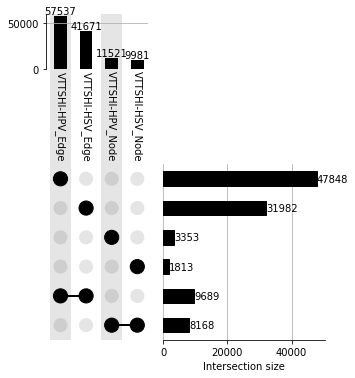

In [60]:
upset = UpSet(Data, show_counts='%d', shading_color=.1, other_dots_color=.1, element_size=None, orientation='vertical')
upset.plot()
Path("Images").mkdir(parents=True, exist_ok=True)
fig = plt.gcf()
fig.set_size_inches(5, 6)
# fig.savefig("Images/Graph_comp.png", dpi=300)
fig.savefig("Images/Graph_comp.pdf", format="pdf", bbox_inches="tight")
type(fig)

    1.d Make a Pandas dataframe object containing the Cytoscape analysis data.

In [61]:
Herpes_Cyto_File = "Cytoscape_network_analysis/Herpes_Open_exp_Open_edgelist.nx default node.csv"
Papilloma_Cyto_File = "Cytoscape_network_analysis/Papillomaviruses_Open_exp_Open_edgelist.nx default node.csv"

Herpes_df = pd.read_csv(Herpes_Cyto_File)
Papilloma_df = pd.read_csv(Papilloma_Cyto_File)

    1.e For creating a Python dictionary object of the wk-shell-decomposition bucket, refer to the following Python definition.

In [62]:
def Bucket(File, Step=10, Print=False):
    # print("\n",File,"\n")
    df = pd.read_csv(File)
    #df = df[["_wkshell","name"]]
    df = df.set_index("name")
    df = df.dropna()
    df['Percentile'] = df._wkshell.rank(pct = True)
    df = df.sort_values('Percentile', ascending = False)
    df = df[["Percentile"]]

    List = [i/100 for i in range(0,100,Step)]
    for i in List:
        df.loc[(df['Percentile'] >= i), 'Bucket'] = int(i*100)
    
    df = df[["Bucket"]]
    d = df.T.to_dict('list')
    Dic = defaultdict(list)
    for i in d:
        # print(i)
        Gene,Bucket = i, str(Step+int(d[i][0])) + "_" + str(int(d[i][0]))
        # Gene,Bucket = i, (Step+int(d[i][0]), int(d[i][0]))
        Dic[Bucket].append(Gene)

    for i in Dic:
        Dic[i] = set(Dic[i])
        if Print:
            print(f"Number of gene in {i} bucket : {len(Dic[i])}")
    return Dic


Herpes_wkshell_bukt = Bucket(Herpes_Cyto_File)
Papilloma_wkshell_bukt = Bucket(Papilloma_Cyto_File)

        1.f Using the following Python function, save 'wk-shell-decomposition bucket' as a gmt (Gene Matrix Transposed file format) file.
    

In [63]:
def Dict_to_gmt(Dic, discription="NA", file_name = "Wkshell_file"):
    from pathlib import Path
    Genes = []

    GMT_Dir = "GMT_base/"
    Path(GMT_Dir).mkdir(parents=True, exist_ok=True)
    
    file_name = GMT_Dir + file_name + ".gmt"
    fh = open(file_name, "w")
    for i in Dic:
        set_name = i
        Items = '\t'.join(set(Dic[i]))
        for j in Dic[i]:
            Genes.append(j)
        print(set_name, discription, Items, sep="\t", file=fh)
        # print(set_name, discription, len(set(Dic[i])))
    
    fh.close()
    Genes = list(set(Genes))
    print(file_name, len(Genes))
    return file_name, Genes

GMT_file_HSV, Genes_HSV = Dict_to_gmt(Herpes_wkshell_bukt, discription="Wk_shell_HSV", file_name = "VTTSHI-HSV")
GMT_file_HPV, Genes_HPV = Dict_to_gmt(Papilloma_wkshell_bukt, discription="Wk_shell_HPV", file_name = "VTTSHI-HPV")
Genes = list(set(Genes_HSV + Genes_HPV))
print(f"\nTotal Number of genes in {len(Genes)}")

GMT_base/VTTSHI-HSV.gmt 8012
GMT_base/VTTSHI-HPV.gmt 9431

Total Number of genes in 11577


    1.g Using the GSEApy Python library to perform bucket-to-bucket enrichment analysis. Select one VTTSHI gmt file as a target (HSV) and another as a query (HPV).

In [64]:
import gseapy as gp
gp.__version__

def Module_Enrichment(gmt, Genes, Gene_set, sig = 'Adjusted P-value', col_name = "Target"):
    print(gmt, len(Genes), len(Gene_set))
    enr = gp.enrichr(gene_list=Gene_set,
                     gene_sets=gmt,
                     description='test_name',
                     outdir='test',
                     background=Genes,
                     cutoff=1 
                    )
    # print(enr.results)
    enr.results = enr.results.rename(columns={'Term':col_name})
    return enr.results[[col_name, sig, 'Overlap']]

    1.h Using the following Python script, perform enrichment of each bucket of the query bucket (HPV) with respect to the target bucket (HSV). A single list of proteins from both networks is used as the background for the enrichment analysis. 

In [65]:
df_list = []

for S in Papilloma_wkshell_bukt:
    
    Gene_set = list(Papilloma_wkshell_bukt[S])
    ench_Df = Module_Enrichment('GMT_base/HSV.gmt', Genes, Gene_set).copy()
    ench_Df['Source'] = S
    
    # ench_Df.loc[ench_Df['Adjusted P-value'] > 0.05, 'Significance'] = 'NE'
    # ench_Df.loc[ench_Df['Adjusted P-value'] <= 0.05, 'Significance'] = '*'
    # ench_Df.loc[ench_Df['Adjusted P-value'] <= 0.01	,'Significance'] = '**'
    # ench_Df.loc[ench_Df['Adjusted P-value'] <  0.01, 'Significance'] = '***'
    ench_Df.loc[ench_Df['Adjusted P-value'] > 0.05, 'Significance'] = 'NE'
    ench_Df.loc[ench_Df['Adjusted P-value'] <= 0.05, 'Significance'] = '*'
    ench_Df.loc[ench_Df['Adjusted P-value'] <= 0.01,'Significance'] = '**'
    ench_Df.loc[ench_Df['Adjusted P-value'] <  0.001, 'Significance'] = '***'
    df_list.append(ench_Df)


GMT_base/HSV.gmt 11577 472
GMT_base/HSV.gmt 11577 1415
GMT_base/HSV.gmt 11577 938
GMT_base/HSV.gmt 11577 945
GMT_base/HSV.gmt 11577 921
GMT_base/HSV.gmt 11577 965
GMT_base/HSV.gmt 11577 945
GMT_base/HSV.gmt 11577 979
GMT_base/HSV.gmt 11577 906
GMT_base/HSV.gmt 11577 945


>> NOTE: Based on enrichment, an 'Adjusted P-value' significance symbol is assigned for further visualization purposes ('***' >> 0.05,  > 0.05 '**' <0.01 and > 0.01'*').

    1.i The following Python script combines all enrichment into one Pandas dataframe object.

In [66]:
df_gseapy = pd.concat(df_list)
df_gseapy.Target.unique()
df_gseapy

,Target,Adjusted P-value,Overlap,Source,Significance
0,100_90,7.205877e-146,197/535,100_90,***
1,10_0,1.000000e+00,9/836,100_90,NE
2,20_10,1.000000e+00,8/743,100_90,NE
3,30_20,1.000000e+00,6/820,100_90,NE
4,40_30,1.000000e+00,10/842,100_90,NE
...,...,...,...,...,...
5,50_40,1.000000e+00,43/765,10_0,NE
6,60_50,1.000000e+00,15/807,10_0,NE
7,70_60,1.000000e+00,32/797,10_0,NE
8,80_70,1.000000e+00,18/800,10_0,NE


        1.j Make a scatter plot of the bucket-to-bucket enrichment analysis using Plotly, where color represents significance level ('green' >> 0.05, > 0.05, 'gold' <0.01 and > 0.01 'yellow') and a non-circle is not significant.

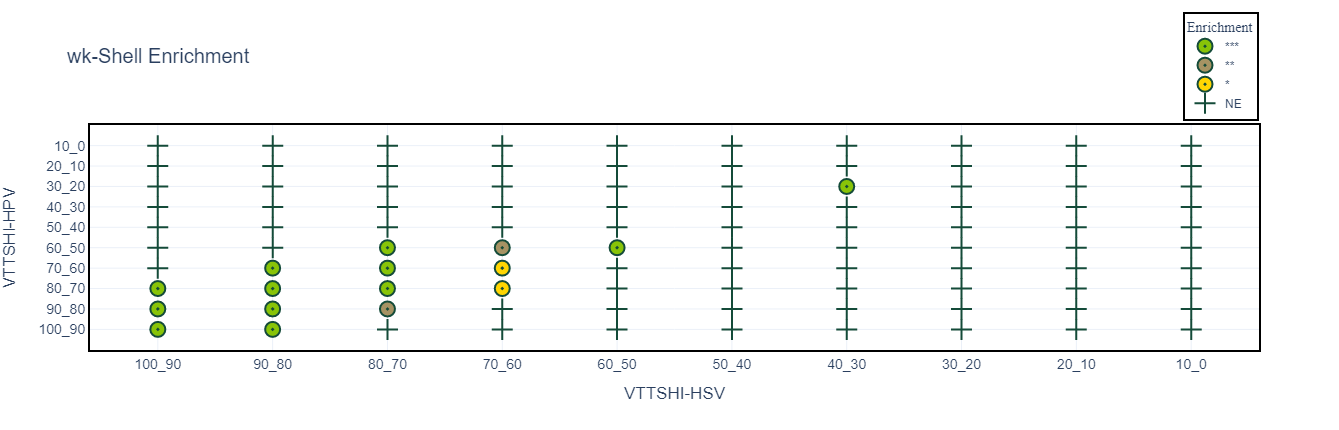

In [67]:
import plotly.express as px
fig = px.scatter(df_gseapy, x="Target", y="Source", color="Significance", symbol = "Significance", 
                category_orders={"Target": ['10_0', '20_10', '30_20', '40_30', '50_40', 
                                            '60_50', '70_60', '80_70', '90_80', '100_90'][::-1]
                                 ,
                                 "Source": ['10_0', '20_10', '30_20', '40_30', '50_40', 
                                            '60_50', '70_60', '80_70', '90_80', '100_90'],
                                 "Significance" : ['***', "**", "*", "NC"],                
                                },
                 color_discrete_map={
                '***' : "#88C408",
                '**' : "#A69363",
                '*': "#FFD602",
                "NE": "#808285"
                 },
                 
                 symbol_map ={
                '***' : 200,
                '**' : 200,
                '*': 200,
                "NE": 33
                 },
                 template="plotly_white",
                )

fig.update_traces(marker=dict(size=15,
                              line=dict(width=2,
                                        color='#144B39')),
                  selector=dict(mode='markers')
                 )

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

# Size of the plot   
fig.update_layout(
    title=f"wk-Shell Enrichment",
    autosize=False,
    width=400,
    height=430,
    # paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(
        title="VTTSHI-HSV"
    ),
    yaxis=dict(
        title="VTTSHI-HPV"
    ),
    font=dict(
        family="Arial",
        size=14,
        # color="black"
    )
)
    
    
# Update legend
fig.update_layout(
    legend=dict(title = f'Enrichment',
        orientation="v",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
        # traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(
            family="Arial",
            size=12,
            # color="black"
        ),
        bgcolor="rgba(0,0,0,0)",
        bordercolor="Black",
        borderwidth=2
    )
)

Path("Images").mkdir(parents=True, exist_ok=True)
fig.write_image("Images/Enrichment_dot.svg")
fig.write_image("Images/Enrichment_dot.png", scale=2)

fig.show()

    1.k To make a Sankey plot that can be used for quantitative analysis, the following Python script can be used.

Length of D1:10, Length of D2:10
535
Generating 20 lables... 
Generating Y 10 Co-ordinates... 
Generating X 10 Co-ordinates... 
Generating edge data ... 


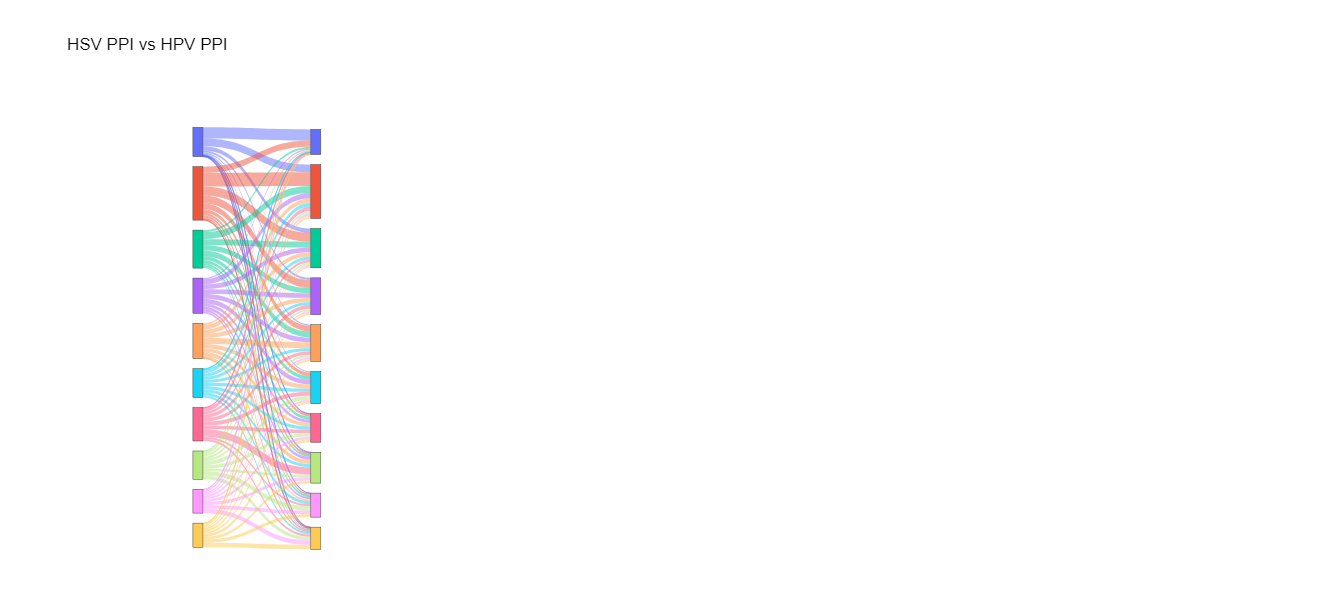

In [68]:
def Sankey_Plot_Wkshell(D1,D2, lab1="A", lab2="B", method="Wkshell", spaceing = 0.05):
    
    def tone_color(H, percent = 50):
        h = H.lstrip('#')
        r,b,g = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
        a = round(percent/100, 2)
        r,b,g,a = map(str, (r,b,g,a))
        rgba = "rgba(" + ", ".join((r,b,g,a))+ ")"
        return(rgba)
    
    print(f"Length of D1:{len(D1)}, Length of D2:{len(D2)}")
    if len(D1) != len(D1):
        print("Not same size!! Killed")
        return
    
    if len(set(D1)-set(D1)):
        print("Dataset doesn't have similar bins!!! Killed")
        return
    
    D1 = {lab1 + " " +k:v for k,v in D1.items()}
    D2 = {lab2 + " " +k:v for k,v in D2.items()}
    
    print(len(D1[lab1 + " " +'100_90']))

    print(f"Generating {2*len(D1)} lables... ")
    label = []
    D1_lab = list(D1)
    if method != "Wkshell":
        D1_lab.sort()
    
    D2_lab = list(D2)
    if method != "Wkshell":
        D2_lab.sort()
    
    Colors = []
    
    for i in range(len(D1_lab)):
        l1, l2 =  D1_lab[i], D2_lab[i]
        Colors.append(px.colors.qualitative.Plotly[i])
        Colors.append(px.colors.qualitative.Plotly[i])
        label.append(l1)
        label.append(l2)
        
    print(f"Generating Y {len(D1)} Co-ordinates... ")
    y = [(i+1)/10 for i in range(len(D1))]
    y = y + y
    y.sort()
    
    print(f"Generating X {len(D1)} Co-ordinates... ")
    x = []
    for i in range(len(D1)):
        x1 = 0.1
        x2 = x1 + spaceing
        x.append(x1)
        x.append(x2)
    
    print(f"Generating edge data ... ")
    source = []
    target = []
    intersection = []
    
    Edges_colors = []
    
    for i in range(len(D1_lab)):
        l1 = D1_lab[i]
        S1 = D1[l1]
        
        for j in range(len(D2_lab)):
            l2 = D2_lab[j]
            S2 = D2[l2]
            I = (S1.intersection(S2))
            source.append(label.index(l1))
            Edges_colors.append(px.colors.qualitative.Plotly[D1_lab.index(l1)])
            target.append(label.index(l2))
            intersection.append(len(I))
            
    Edges_colors = [tone_color(h) for h in Edges_colors]        
    fig = go.Figure(go.Sankey(
    textfont=dict(color="rgba(0,0,0,0)", size=1),
    arrangement = "snap",
    node = {
        "label": label,
        "x": x,
        "y": y,
        'pad':10, 'thickness' : 10,
        'color' : Colors,
    },  
    link = {
        "source": source,
        "target": target,
        "value": intersection
    }))

    fig.update_traces(orientation='h', selector=dict(type='sankey'))
    fig.update_traces(link_color=Edges_colors, selector=dict(type='sankey'))
    fig.update_layout({
        'plot_bgcolor': 'rgba(0, 0, 0, 0)',
        'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
    
    fig.update_layout(
    title=f'',
    autosize=False,
    width=1000,
    height=600,
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis=dict(
        title="Type of Network"),
    yaxis=dict(title=""))
    
    fig.update_layout(
    title=f"{lab1} PPI vs {lab2} PPI",
    font=dict(
        family="Arial",
        size=12,
        color="black"))
    return fig

fig = Sankey_Plot_Wkshell(Herpes_wkshell_bukt, Papilloma_wkshell_bukt, lab1="HSV", lab2="HPV", spaceing = 0.1)

fig.write_image("Images/Sanky_plot.pdf")
fig.write_image("Images/Sanky_plot.png")
fig.write_image("Images/Sanky_count_plot.svg")
fig.write_image("Images/Sanky_count_plot.webp")
# fig.write_image("Images/Sanky_count_plot.eps")
fig.write_html("Images/Sanky_count_plot.html")

fig.show()


## 7. Protein prioritization and Viral protein enrichment.

>> TIMING: ~5 min

To demonstrate the integration of networks centrality and enrichment analysis, we use only VTTSHI-HPV as an example.

In [69]:
Papilloma_df = pd.read_csv(Papilloma_Cyto_File)
gene_list = Papilloma_df.name
gene_list

# convert dataframe or series to list
glist = gene_list.squeeze().str.strip().tolist()
print(glist[:10])

['O15484', 'Q8N3S3', 'Q8NFN8', 'Q8N699', 'P04070', 'P35716', 'Q9P2H3', 'Q9UMS5', 'Q96K31', 'P02452']


    1. Using UniProt Python API, map UniProtKB IDs to gene names.


In [70]:
import urllib.parse
import urllib.request

url = 'https://www.uniprot.org/uploadlists/'

params = {
'from': 'ACC+ID',
'to': 'GENENAME',
'format': 'tab',
'query': " ".join(glist)
}

data = urllib.parse.urlencode(params)
data = data.encode('utf-8')
req = urllib.request.Request(url, data)
with urllib.request.urlopen(req) as f:
   response = f.read()

LOL = []
for i in response.decode('utf-8').splitlines():
    LOL.append(i.split())
    
df = pd.DataFrame(LOL)

new_header = df.iloc[0] 
df = df[1:] 
df.columns = new_header 
df.head(5)

UniportKB_to_Genename = dict(zip(df.From, df.To))

Papilloma_df.replace({'shared name': UniportKB_to_Genename}, inplace=True)
Papilloma_df.rename(columns={"shared name": "GeneName"}, inplace=True)
Papilloma_df.rename(columns={"_wks_percentile_bucket": "wk-shell"}, inplace=True)
Papilloma_df

,SUID,wk-shell,_wkshell,AverageShortestPathLength,BetweennessCentrality,ClosenessCentrality,ClusteringCoefficient,Degree,Eccentricity,IsSingleNode,...,NeighborhoodConnectivity,NumberOfDirectedEdges,NumberOfUndirectedEdges,PartnerOfMultiEdgedNodePairs,Radiality,selected,SelfLoops,GeneName,Stress,TopologicalCoefficient
0,72,0,3,5.815510,0.000000,0.171954,0.000000,1,8,False,...,4.000000,1,0,0,0.464943,False,0,CAPN5,0,0.000000
1,73,0,3,5.815510,0.000000,0.171954,0.000000,1,8,False,...,4.000000,1,0,0,0.464943,False,0,PHTF2,0,0.000000
2,74,0,3,5.815510,0.000000,0.171954,0.000000,1,8,False,...,4.000000,1,0,0,0.464943,False,0,GPR156,0,0.000000
3,75,0,2,5.280182,0.000000,0.189387,0.000000,1,8,False,...,2.000000,1,0,0,0.524424,False,0,MYCT1,0,0.000000
4,76,0,2,5.378634,0.000000,0.185921,0.000000,1,8,False,...,2.000000,1,0,0,0.513485,False,0,PROC,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9426,9498,95,731,2.897199,0.002913,0.345161,0.034177,80,6,False,...,41.737500,80,0,0,0.789200,False,0,TOMM40,5341184,0.021698
9427,9499,95,537,3.199873,0.001470,0.312512,0.016194,39,6,False,...,20.564103,39,0,0,0.755570,False,0,FIS1,2308290,0.037730
9428,9500,10,38,3.939953,0.000011,0.253810,0.000000,3,6,False,...,26.666667,3,0,0,0.673339,False,0,SPOCK1,5434,0.333333
9429,9501,5,22,4.541163,0.000221,0.220208,0.000000,5,7,False,...,4.800000,5,0,0,0.606537,False,0,UPK1B,335102,0.211111


 2. The following Python script keeps only the desired columns and discards the rest.


In [71]:
Papilloma_df = Papilloma_df[['name','GeneName',
 'BetweennessCentrality',
 'ClosenessCentrality',
 'ClusteringCoefficient',
 'Degree',
 'Radiality',
 'Stress',
 'TopologicalCoefficient']]

Papilloma_df.set_index(['name', 'GeneName'], inplace=True)
Papilloma_df.head(5)

,,BetweennessCentrality,ClosenessCentrality,ClusteringCoefficient,Degree,Radiality,Stress,TopologicalCoefficient
name,GeneName,,,,,,,
O15484,CAPN5,0.0,0.171954,0.0,1,0.464943,0,0.0
Q8N3S3,PHTF2,0.0,0.171954,0.0,1,0.464943,0,0.0
Q8NFN8,GPR156,0.0,0.171954,0.0,1,0.464943,0,0.0
Q8N699,MYCT1,0.0,0.189387,0.0,1,0.524424,0,0.0
P04070,PROC,0.0,0.185921,0.0,1,0.513485,0,0.0


    3. The best way to visualize the centralities selected is to rescale the values and select the top 20 genes from the list.

In [72]:
Papilloma_df['Sum'] = Papilloma_df.loc[:,:].sum(axis=1)
Papilloma_df.sort_values(by=['Sum'], ascending=False, inplace=True)

list(Papilloma_df)
Top_20 = Papilloma_df[['BetweennessCentrality',
 'ClosenessCentrality',
 'ClusteringCoefficient',
 'Degree',
 'Radiality',
 'Stress',
 'TopologicalCoefficient']].head(20)

Top_20 -= Top_20.min()
Top_20 /= Top_20.max()

Top_20 = Top_20.reset_index()
Top_20.index += 1



df = Top_20[list(Top_20)[2:]]
Cols = list(df)
Col_dict = {Cols[i]:i+1 for i in range(len(Cols))}
df.index = list(Top_20.GeneName)

df.head(5)

glist = list(df.index) 
print(len(glist))
print(*glist, sep="; ")


20
HNRNPH1; YWHAG; BAG2; C1QBP; PCNA; CIT; PHB2; CCT7; TUBA4A; CCT4; BYSL; PLEKHA4; MYC; RRBP1; MRPL12; EMD; ACTG1; SHC1; SP1; LGALS1


 4. Using the Enrichr databases, select the enrichment databases that you want to use. Python script queries all databases with the "Virus" keyword and then selects the "VirusMINT" database. 


In [73]:
# https://academic.oup.com/nar/article/44/W1/W90/2499357
# https://maayanlab.cloud/Enrichr/#libraries
names = gp.get_library_name(organism='Human') # default: Human
for db in names:
    if 'VIRUS' in db.upper():
        print(db)
        
gene_sets=['VirusMINT']
gene_sets

Virus-Host_PPI_P-HIPSTer_2020
VirusMINT
Virus_Perturbations_from_GEO_down
Virus_Perturbations_from_GEO_up


['VirusMINT']

 5. Enrichr Python API is used in the following Python script to perform enrichment analysis. 

In [74]:
enr = gp.enrichr(gene_list=glist, gene_sets=gene_sets, organism='Human', description='VirusMINT', outdir='VirusMINT', cutoff=1)
enr.results.head(5)

encrihment_df = enr.results[enr.results['Adjusted P-value'] <= 0.005]
Encrihment_dict = defaultdict(list)
for Term, Genes in encrihment_df[['Term', 'Genes']].values.tolist():
    for gene in Genes.split(';'):
        Encrihment_dict[gene].append(Term)
        
for i in Encrihment_dict:
    Encrihment_dict[i] = "<br>".join(Encrihment_dict[i])
    
Encrihment_dict = dict(Encrihment_dict)

    6. Preprocessing the Enrichr results to create a dot plot is performed by the following Python script.


In [75]:
x = []
y = []
size = []
text = []
groups = []

for c in Col_dict:
    I = list(df[c].index)
    for i in I:
        y.append(i)
        x.append(c) #Col_dict[c]
        E = 'NE'
        if i in Encrihment_dict:
            # print(i, Encrihment_dict[i])
            E = Encrihment_dict[i]
        groups.append(E)
        
    for s in df[c].values:
        size.append(s)
        text.append("<br>".join([str(round(s, 2)), c]))

    
Dot_plot_df = pd.DataFrame({"Centrality":x,
                           "Protein":y,
                           "Value":size,
                           "Info":text,
                           "Encrichment":groups})
Dot_plot_df.head(5)

,Centrality,Protein,Value,Info,Encrichment
0,BetweennessCentrality,HNRNPH1,1.000000,1.0<br>BetweennessCentrality,NE
1,BetweennessCentrality,YWHAG,0.430560,0.43<br>BetweennessCentrality,NE
2,BetweennessCentrality,BAG2,0.176601,0.18<br>BetweennessCentrality,Homo sapiens
3,BetweennessCentrality,C1QBP,0.202625,0.2<br>BetweennessCentrality,Human immunodeficiency virus 1
4,BetweennessCentrality,PCNA,0.134775,0.13<br>BetweennessCentrality,Human herpesvirus 1 (strain 17)


    7.a Using Plotly Python library, the following Python script makes a dot plot.


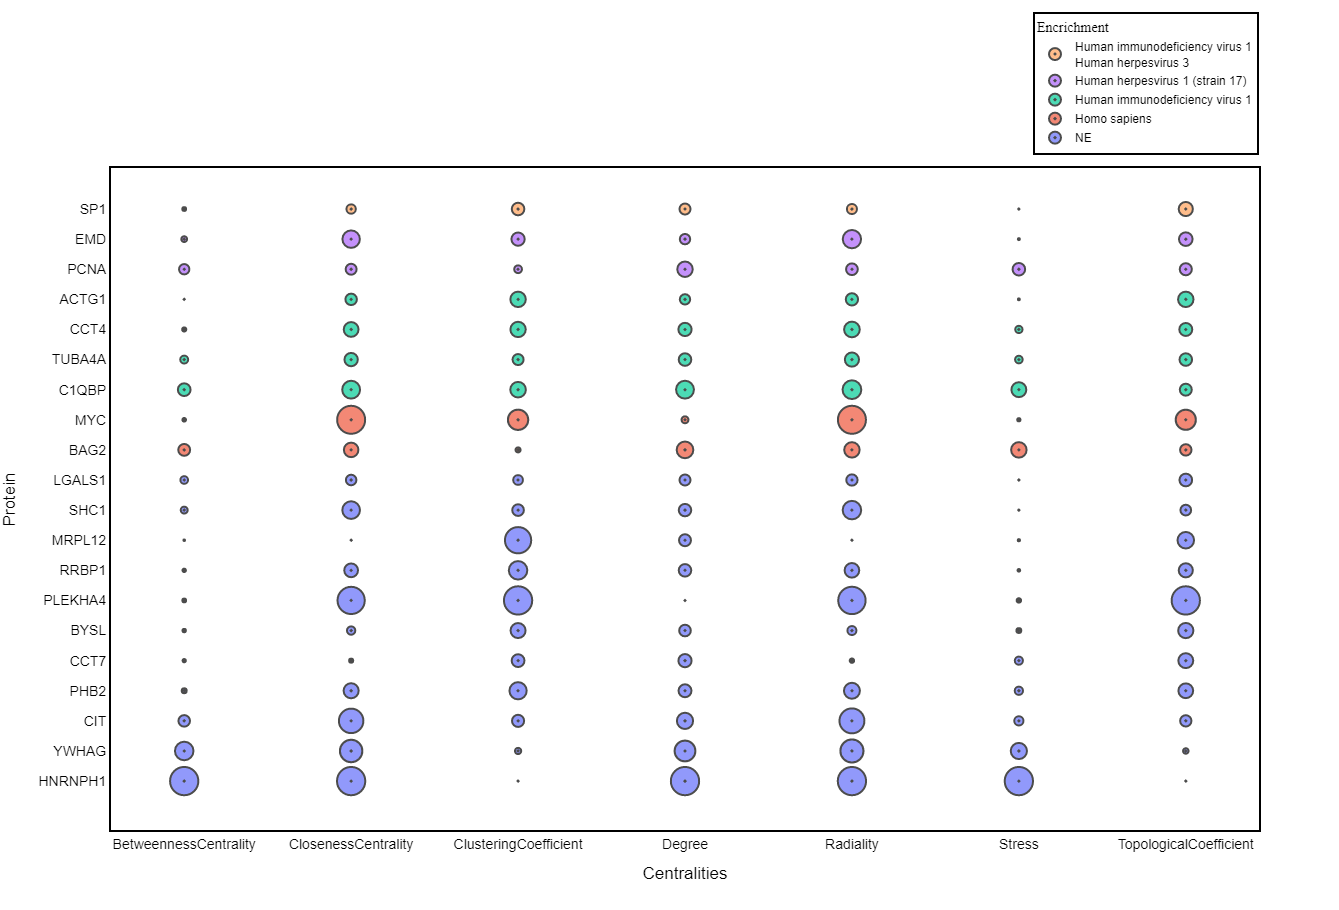

In [76]:
import plotly.express as px

# Make Scaterplot
fig = px.scatter(Dot_plot_df, x="Centrality", y="Protein", size="Value", color="Encrichment", hover_data=['Info'])

fig.update_traces(mode='markers', marker_symbol = 200, marker_line_width=2, marker_line_color='rgba(0, 0, 0, 1)')
fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.update_layout(title=None, autosize=False, width=420, height=910, plot_bgcolor='rgba(0,0,0,0)', xaxis=dict(
        title="Centralities"),
    yaxis=dict(title="Protein"),
    font=dict(family="Arial", size=14, color="black"))

fig.update_layout(
    legend=dict(orientation="v", yanchor="bottom", y=1.02, xanchor="right", x=1, traceorder="reversed",
        title_font_family="Times New Roman",
        font=dict(family="Arial", size=12, color="black"), bgcolor="rgba(0,0,0,0)", bordercolor="Black", borderwidth=2)
)

fig.write_image("Images/Dot_plot.pdf")
fig.write_image("Images/Dot_plot.svg")
fig.write_image("Images/Dot_plot.webp")
fig.write_image("Images/Dot_plot.png")
fig.write_html("Images/Dot_plot.html")


fig_dots = fig

fig_dots.show()

    7.a A relative dot size legend is generated by the following Python script.

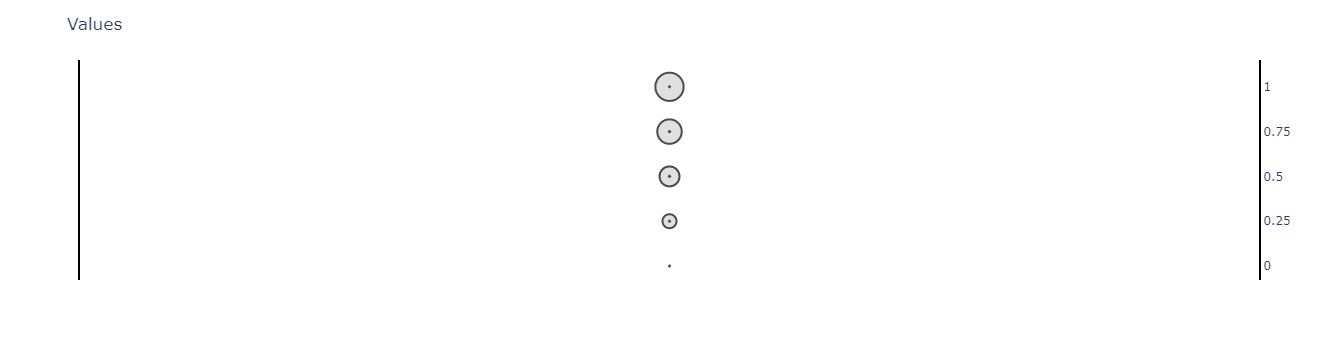

In [78]:
fig = px.scatter(x=['', '', '', '', ''], y=[0, 0.25, 0.5, 0.75, 1], size = [0, .25, .50, .75, 1])

fig.update_traces(mode='markers', marker_symbol = 200, marker_line_width=2, marker_line_color='rgba(0, 0, 0, 1)')
fig.update_traces(marker=dict(color='lightgray'))
fig.update_xaxes(visible=False)
fig.update_yaxes(ticklabelposition="outside right", side= 'right')
fig.update_yaxes(tick0=0, dtick=0.25)
fig.update_xaxes(tick0=0, dtick=0)

fig.update_xaxes(showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(showline=True, linewidth=2, linecolor='black', mirror=True)

fig.update_layout(title=f'Values', autosize=False, width=200, height=290, plot_bgcolor='rgba(0,0,0,0)', yaxis=dict(title=None))

fig.write_image("Images/Dot_legend_plot.pdf")
fig.write_image("Images/Dot_legend_plot.svg")
fig.write_image("Images/Dot_legend_plot.webp")
fig.write_image("Images/Dot_legend_plot.png")
fig.write_html("Images/Dot_legend_plot.html")

fig_radius = fig
fig_radius.show()

>> CRITICAL: VTTSHI-HPV serves as an example of the integration of networks centrality and enrichment analysis. However, the same steps can be applied to any data set, VTTSHI-HPV or other appropriate datasets. 
